<a href="https://colab.research.google.com/github/TranNhiem/Heuristic_attention_represenation_learning_ssl/blob/main/tensorflow/Augmentation_trategy/Heuristic_Attention_Data_Augmentation_Strategies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heuristic Attention Representation Data Augmentation 

1. Strategy SimCLR Augmentation Strategy (Random Crop)
2. Strategy SimCLR Augmentation Strategy (Inception Style Crop) 
**Reference for Inecption Style**
https://github.com/AdityaKane2001/regnety/blob/main/regnety/dataset/imagenet.py 
## Part 1 Two Views Augmentation 
**Reference SimCLR paper**
https://github.com/google-research/simclr/blob/master/tf2/data_util.py 

  + SimCLR Augment (Random_Crop) 
  + SimCLR Augment (Inception style Crop)

## Part 2 Multi Views Augmentation
**Reference Building Multi_Views**
https://colab.research.google.com/github/ayulockin/SwAV-TF/blob/master/initial_notebooks/Building_MultiCropDataset.ipynb 

  + Global Views 224 (2 views)
  + Local Views 96 (4 to 6 Views) 96

In [ ]:
!pip install imgaug==0.4.0 --quiet

In [ ]:
!pip install tf-models-official --quiet

In [ ]:
## Get Tiny ImageNet Data
!wget 'https://hanlab.mit.edu/files/OnceForAll/ofa_cvpr_tutorial/imagenet_1k.zip'

In [ ]:
!unzip imagenet_1k.zip  

In [36]:
import os
from imutils import paths
from numpy import load
from scipy.ndimage.interpolation import zoom
import tensorflow as tf
import numpy as np
from tensorflow.python.training import optimizer
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt

In [37]:
AUTO = tf.data.experimental.AUTOTUNE
IMG_SIZE=224
BATCH_SIZE =32
SEED=26
crop_size=224

# Get Image Path and list image_path
imagenet_path="./imagenet_1k"



## SimCLR Two Augmentation Policy (Random Crop) --> 

**Helper Functions**

In [38]:
'''Helper Functions Reading Data '''
## Reading image given path
def parse_images(image_path,):
  ## Loading and reading Image 
  img= tf.io.read_file(image_path)
  img= tf.io.decode_jpeg(img, channels=3)

  # print(label)
  return img

'''Helper Functions Data Augmentation '''
### This section for Random Blur 
def gaussian_blur(image, kernel_size, sigma, padding='SAME'):
  """Blurs the given image with separable convolution.
  Args:
    image: Tensor of shape [height, width, channels] and dtype float to blur.
    kernel_size: Integer Tensor for the size of the blur kernel. This is should
      be an odd number. If it is an even number, the actual kernel size will be
      size + 1.
    sigma: Sigma value for gaussian operator.
    padding: Padding to use for the convolution. Typically 'SAME' or 'VALID'.
  Returns:
    A Tensor representing the blurred image.
  """
  radius = tf.cast((kernel_size / 2), dtype=tf.int32)
  kernel_size = radius * 2 + 1
  x = tf.cast(tf.range(-radius, radius + 1), dtype=tf.float32)
  blur_filter = tf.exp(
      -tf.pow(x, 2.0) / (2.0 * tf.pow(tf.cast(sigma, dtype=tf.float32), 2.0)))
  blur_filter /= tf.reduce_sum(blur_filter)
  # One vertical and one horizontal filter.
  blur_v = tf.reshape(blur_filter, [kernel_size, 1, 1, 1])
  blur_h = tf.reshape(blur_filter, [1, kernel_size, 1, 1])
  num_channels = tf.shape(image)[-1]
  blur_h = tf.tile(blur_h, [1, 1, num_channels, 1])
  blur_v = tf.tile(blur_v, [1, 1, num_channels, 1])
  expand_batch_dim = image.shape.ndims == 3
  if expand_batch_dim:
    # Tensorflow requires batched input to convolutions, which we can fake with
    # an extra dimension.
    image = tf.expand_dims(image, axis=0)
  blurred = tf.nn.depthwise_conv2d(
      image, blur_h, strides=[1, 1, 1, 1], padding=padding)
  blurred = tf.nn.depthwise_conv2d(
      blurred, blur_v, strides=[1, 1, 1, 1], padding=padding)
  if expand_batch_dim:
    blurred = tf.squeeze(blurred, axis=0)
  return blurred

### Random Apply with Probability
def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
      return func(x)
    else:
        return x

## SimCLR Augmentation Croping 
def _compute_crop_shape(
    image_height, image_width, aspect_ratio, crop_proportion):
  """Compute aspect ratio-preserving shape for central crop.
  The resulting shape retains `crop_proportion` along one side and a proportion
  less than or equal to `crop_proportion` along the other side.
  Args:
    image_height: Height of image to be cropped.
    image_width: Width of image to be cropped.
    aspect_ratio: Desired aspect ratio (width / height) of output.
    crop_proportion: Proportion of image to retain along the less-cropped side.
  Returns:
    crop_height: Height of image after cropping.
    crop_width: Width of image after cropping.
  """
  image_width_float = tf.cast(image_width, tf.float32)
  image_height_float = tf.cast(image_height, tf.float32)

  def _requested_aspect_ratio_wider_than_image():
    crop_height = tf.cast(
        tf.math.rint(crop_proportion / aspect_ratio * image_width_float),
        tf.int32)
    crop_width = tf.cast(
        tf.math.rint(crop_proportion * image_width_float), tf.int32)
    return crop_height, crop_width

  def _image_wider_than_requested_aspect_ratio():
    crop_height = tf.cast(
        tf.math.rint(crop_proportion * image_height_float), tf.int32)
    crop_width = tf.cast(
        tf.math.rint(crop_proportion * aspect_ratio * image_height_float),
        tf.int32)
    return crop_height, crop_width

  return tf.cond(
      aspect_ratio > image_width_float / image_height_float,
      _requested_aspect_ratio_wider_than_image,
      _image_wider_than_requested_aspect_ratio)


def center_crop(image, height, width, crop_proportion):
  """Crops to center of image and rescales to desired size.
  Args:
    image: Image Tensor to crop.
    height: Height of image to be cropped.
    width: Width of image to be cropped.
    crop_proportion: Proportion of image to retain along the less-cropped side.
  Returns:
    A `height` x `width` x channels Tensor holding a central crop of `image`.
  """
  shape = tf.shape(image)
  image_height = shape[0]
  image_width = shape[1]
  crop_height, crop_width = _compute_crop_shape(
      image_height, image_width, height / width, crop_proportion)
  offset_height = ((image_height - crop_height) + 1) // 2
  offset_width = ((image_width - crop_width) + 1) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_height, offset_width, crop_height, crop_width)

  image = tf.image.resize([image], [height, width],
                          method=tf.image.ResizeMethod.BICUBIC)[0]

  return image

def distorted_bounding_box_crop(image,
                                bbox,
                                min_object_covered=0.1,
                                aspect_ratio_range=(0.75, 1.33),
                                area_range=(0.05, 1.0),
                                max_attempts=100,
                                scope=None):
  """Generates cropped_image using one of the bboxes randomly distorted.
  See `tf.image.sample_distorted_bounding_box` for more documentation.
  Args:
    image: `Tensor` of image data.
    bbox: `Tensor` of bounding boxes arranged `[1, num_boxes, coords]`
        where each coordinate is [0, 1) and the coordinates are arranged
        as `[ymin, xmin, ymax, xmax]`. If num_boxes is 0 then use the whole
        image.
    min_object_covered: An optional `float`. Defaults to `0.1`. The cropped
        area of the image must contain at least this fraction of any bounding
        box supplied.
    aspect_ratio_range: An optional list of `float`s. The cropped area of the
        image must have an aspect ratio = width / height within this range.
    area_range: An optional list of `float`s. The cropped area of the image
        must contain a fraction of the supplied image within in this range.
    max_attempts: An optional `int`. Number of attempts at generating a cropped
        region of the image of the specified constraints. After `max_attempts`
        failures, return the entire image.
    scope: Optional `str` for name scope.
  Returns:
    (cropped image `Tensor`, distorted bbox `Tensor`).
  """
  with tf.name_scope(scope or 'distorted_bounding_box_crop'):
    shape = tf.shape(image)
    sample_distorted_bounding_box = tf.image.sample_distorted_bounding_box(
        shape,
        bounding_boxes=bbox,
        min_object_covered=min_object_covered,
        aspect_ratio_range=aspect_ratio_range,
        area_range=area_range,
        max_attempts=max_attempts,
        use_image_if_no_bounding_boxes=True)
    bbox_begin, bbox_size, _ = sample_distorted_bounding_box

    # Crop the image to the specified bounding box.
    offset_y, offset_x, _ = tf.unstack(bbox_begin)
    target_height, target_width, _ = tf.unstack(bbox_size)
    image = tf.image.crop_to_bounding_box(
        image, offset_y, offset_x, target_height, target_width)

    return image




### List Augmentation Transformations Random Crop + Flipping -- Color Distortion --> Color Drop --> Random Blur. 
+ Reference BYOL Paper https://arxiv.org/abs/2006.07733
+ SimCLR Paper https://arxiv.org/abs/2002.05709 

In [48]:
# Alternative two option for random_crop (Simclr_github)
def flip_random_crop(image, crop_size): 
  '''
  Args: 
    image: tensor shape of [height, width, channels]
    crop_size: using for random crop 
  Return: 
    A tensor transform with Flipping and Crop same_size as image if Crop==img_size
  '''
  image= tf.image.random_flip_left_right(image)
  image= tf.image.random_crop(image, (crop_size, crop_size, 3))
  
  return image
# Local Croping --Under experiment
def random_crop_flip_resize(image, IMG_SIZE):
    # Random cropping
    h_crop = tf.cast(tf.random.uniform(shape=[], minval=13,
                     maxval=33, dtype=tf.int32), tf.float32)
    
    w_crop = h_crop * tf.random.uniform(shape=[], minval=0.67, maxval=1.0)
    h_crop, w_crop = tf.cast(h_crop, tf.int32), tf.cast(w_crop, tf.int32)

    opposite_aspectratio = tf.random.uniform(shape=[])

    if opposite_aspectratio < 0.5:
        h_crop, w_crop = w_crop, h_crop
    image = tf.image.random_crop(image, size=[h_crop, w_crop, 3])

    # Horizontal flipping
    horizontal_flip = tf.random.uniform(shape=[])
    if horizontal_flip < 0.5:
        image = tf.image.random_flip_left_right(image)

    # Resizing to original size
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
    
    return image

## Inception Style Croping 
def inception_style_croping(image, height, width):
  """Make a random crop and resize it to height `height` and width `width`.
  Args:
    image: Tensor representing the image.
    height: Desired image height.
    width: Desired image width.
  Returns:
    A `height` x `width` x channels Tensor holding a random crop of `image`.
  """
  bbox = tf.constant([0.0, 0.0, 1.0, 1.0], dtype=tf.float32, shape=[1, 1, 4])
  aspect_ratio = width / height
  image = distorted_bounding_box_crop(
      image,
      bbox,
      min_object_covered=0.1,
      aspect_ratio_range=(3. / 4 * aspect_ratio, 4. / 3. * aspect_ratio),
      area_range=(0.08, 1.0),
      max_attempts=100,
      scope=None)
  return tf.image.resize([image], [height, width],
                         method=tf.image.ResizeMethod.BICUBIC)[0]

## This random brightness implement in SimCLRV2
# Magnitude reference form BYOL
def color_jitter(image, strength=[0.4, 0.4, 0.2, 0.1 ]):
  '''
  Args: 
    image: tensor shape of [height, width, channels]
    strength: lists of intensity for color distortion
  Return 
    A distortion transofrm tensor[height, width, channels]
  '''
  x= tf.image.random_brightness(image, max_delta=0.8* strength[0])
  x= tf.image.random_contrast(x, lower=1-0.8 *strength[1], upper= 1 + 0.8* strength[1])
  x= tf.image.random_saturation(x, lower=1-0.8*strength[2], upper= 1+ 0.8* strength[2]) 
  x= tf.image.random_hue(x, max_delta=0.2*strength[3])
  ## Color distor transform can disturb the natural range of RGB -> Hence ->clib by value
  x= tf.clip_by_value(x, 0, 255)
  return x

def random_blur(image): # IMG_SIZE=32,
  '''
  Args: 
    Image: A tensor [height, width, channels]
    IMG_SIZE: image_size 
    p: probability of applying transformation 
  Returns: 
    A image tensor that Blur
  '''
  #print(image.shape)
  IMG_SIZE= image.shape[1]
  #print(IMG_SIZE)
  sigma= tf.random.uniform([], 0.1, 2.0, dtype= tf.float32)
  image_blur= gaussian_blur(image, kernel_size=IMG_SIZE //10, sigma= sigma,padding='SAME')
  return image_blur

def color_drop(image): 
  '''
  Args: 
    image: Tensor shape of [Height, width, channels]

  Return:
    A convert RGB-> gray transform 
  '''
  x= tf.image.rgb_to_grayscale(image)
  x= tf.tile(x, [1, 1, 3])
  return x

def simclr_augment_randcrop(image, IMG_SIZE): 
  #IMG_SIZE=IMG_SIZE
  # As discussed in the SimCLR paper, the series of augmentation
  # transformations (except for random crops) need to be applied
  # randomly to impose translational invariance. (Two Options implementation)
  image= flip_random_crop(image, crop_size)
  #image= random_crop_flip_resize(image, IMG_SIZE)
  image= random_apply(color_jitter, p=0.8, x=image, )
  image= random_apply(color_drop,p=0.2, x=image, )
  image= random_apply(random_blur, p=1.0, x= image,)
  return image


def simclr_augment_inception_style(image, IMG_SIZE): 
  #IMG_SIZE=IMG_SIZE
  # As discussed in the SimCLR paper, the series of augmentation
  # transformations (except for random crops) need to be applied
  # randomly to impose translational invariance. (Two Options implementation)
  #image= flip_random_crop(image, crop_size)

  image= inception_style_croping(image, IMG_SIZE, IMG_SIZE)
  
  image= random_apply(color_jitter, p=0.8, x=image, )
  image= random_apply(color_drop,p=0.2, x=image, )
  image= random_apply(random_blur, p=1.0, x= image,)
  return image


### Testing Augmentation & Visualization

In [40]:
class simclr_augmentation_testing():

  def __init__(self, IMG_SIZE, BATCH_SIZE, img_path):
    self.IMG_SIZE = IMG_SIZE
    self.BATCH_SIZE = BATCH_SIZE
    self.x_train = list(paths.list_images(img_path))
  
  @classmethod
  def parse_images(self, image_path):
      # Loading and reading Image
      img = tf.io.read_file(image_path)
      img = tf.io.decode_jpeg(img, channels=3)
      #img=tf.image.convert_image_dtype(img, tf.float32)
      return img

  @classmethod
  def parse_Binary_mask(self, mask_path):
      # Loading and reading Image
      bi_mask = tf.io.read_file(mask_path)
      bi_mask = tf.io.decode_jpeg(bi_mask, channels=1)
      #img=tf.image.convert_image_dtype(img, tf.float32)
      return img

  @property
  def original_ds(self):
    train_ds = (tf.data.Dataset.from_tensor_slices(self.x_train)
                .shuffle(self.BATCH_SIZE * 100, seed=SEED)
                .map(self.parse_images,  num_parallel_calls=AUTO)
                .map(lambda x: (tf.image.resize(x, (self.IMG_SIZE, self.IMG_SIZE))),
                      num_parallel_calls=AUTO,)
              .batch(self.BATCH_SIZE)
              .prefetch(AUTO)
              )

    return train_ds
    
  @property
  def simclr_randcrop(self):

    train_ds_one = (tf.data.Dataset.from_tensor_slices(self.x_train)
                      .shuffle(self.BATCH_SIZE * 100, seed=SEED)
                      .map(self.parse_images,  num_parallel_calls=AUTO)
                      .map(lambda x: (tf.image.resize(x, (self.IMG_SIZE, self.IMG_SIZE))),
                            num_parallel_calls=AUTO,
                            )
                      .map(lambda x: (simclr_augment_randcrop(x, self.IMG_SIZE)), num_parallel_calls=AUTO)
                      .batch(self.BATCH_SIZE)
                      .prefetch(AUTO)
                      )

    # train_ds_two = (tf.data.Dataset.from_tensor_slices(self.x_train)
    #                   .shuffle(self.BATCH_SIZE * 100, seed=SEED)
    #                   .map(self.parse_images,  num_parallel_calls=AUTO)
    #                   .map(lambda x: (tf.image.resize(x, (self.IMG_SIZE, self.IMG_SIZE))),
    #                        num_parallel_calls=AUTO,
    #                        )
    #                   .map(lambda x: (simclr_augment_randcrop(x, self.IMG_SIZE)), num_parallel_calls=AUTO)
    #                   .batch(self.BATCH_SIZE)
    #                   .prefetch(AUTO)
    #                   )
    #train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))
    return train_ds_one

  @property
  def simclr_inception_style_crop(self):

    train_ds_one = (tf.data.Dataset.from_tensor_slices(self.x_train)
                      .shuffle(self.BATCH_SIZE * 100, seed=SEED)
                      .map(self.parse_images,  num_parallel_calls=AUTO)
                      .map(lambda x: (tf.image.resize(x, (self.IMG_SIZE, self.IMG_SIZE))),
                            num_parallel_calls=AUTO,
                            )
                      .map(lambda x: (simclr_augment_inception_style(x, self.IMG_SIZE)), num_parallel_calls=AUTO)
                      .batch(self.BATCH_SIZE)
                      .prefetch(AUTO)
                      )

    return train_ds_one

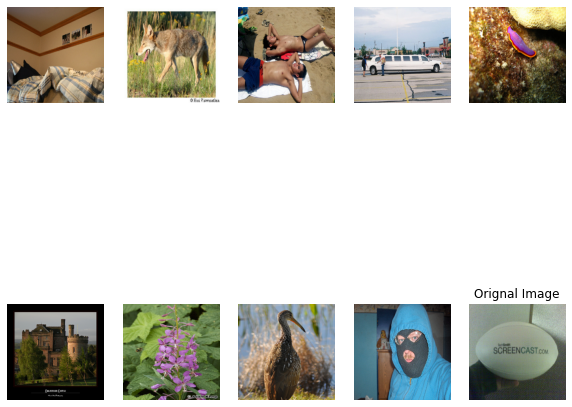

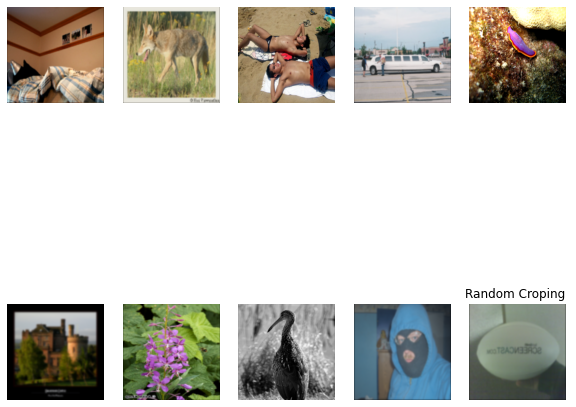

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


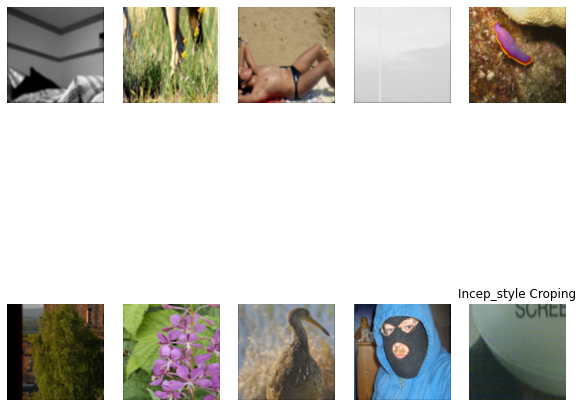

In [49]:
data= simclr_augmentation_testing(IMG_SIZE, BATCH_SIZE, imagenet_path)
original_ds_test= data.original_ds
simclr_randcrop_ds= data.simclr_randcrop
simclr_inception_style_crop= data.simclr_inception_style_crop
# Ensure that the different versions of the dataset actually contain
# identical images.

sample_images_one= next(iter(original_ds_test))
plt.figure(figsize=(10, 10))
for n in range(10):
    ax = plt.subplot(2, 5, n + 1)
    plt.imshow(sample_images_one[n]/255)#.numpy().astype("int")
    plt.axis("off")
plt.title("Orignal Image")
plt.show()


sample_images_two= next(iter(simclr_randcrop_ds))
plt.figure(figsize=(10, 10))
for n in range(10):
    ax = plt.subplot(2, 5, n + 1)
    plt.imshow(sample_images_two[n]/255)#.numpy().astype("int")
    plt.axis("off")
plt.title("Random Croping ")
plt.show()


sample_images_two= next(iter(simclr_inception_style_crop))
plt.figure(figsize=(10, 10))
for n in range(10):
    ax = plt.subplot(2, 5, n + 1)
    plt.imshow(sample_images_two[n]/255)#.numpy().astype("int")
    plt.axis("off")

plt.title("Incep_style Croping")
plt.show()


## SimCLR Multi_Views Augmentation Policy 

In [ ]:
## Check out the Link above for detail Implementation